In [42]:
# Colab setup
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("IN_COLAB=", IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive/")
    os.chdir('/content/drive/MyDrive/Denoise/cxr-denoise/training')
    !pip install -r ../requirements.txt -q
    print("Requirements installed!")

IN_COLAB= False


In [43]:
# Enviorment setup
import os
import torch
import numpy as np
import random

# Seeding
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# TODO (optional): fix xpu support
print("Using:", device)

Using: cpu


In [44]:
# Get dataset from drive in colab - else sets DATA_PATH
# expect <5 min for 512², or <20 for 1024²
if IN_COLAB:
    import zipfile

    ZIP_PATH = "/content/drive/MyDrive/Datasets/NIH_data_512.zip"
    UNZIP_PATH = "/content/data/NIH_data_512"

    if not os.path.exists(UNZIP_PATH):
        os.makedirs(UNZIP_PATH, exist_ok=True)
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(UNZIP_PATH)
    DATA_PATH = "/content/data/NIH_data_512/content/NIH_data_512/" # TODO: fix redundent "content" - likely mistake in zipping
else:
    DATA_PATH = "../data/NIH_data_512"

In [45]:
# Load NIH Dataset
from nih_dataset import NIH_Dataset, RandomPatchDataset
from torch.utils.data import DataLoader
from noise import PreprocessClean, ApplyNoise
import torch
from PIL import Image
from torchvision import transforms

PRELOAD_TO_RAM = IN_COLAB

if not ('already_in_ram' in globals() or 'already_in_ram' in locals()): # dirty check to avoid reloading to ram
    nih_train = NIH_Dataset(DATA_PATH, split="train", preload_to_ram=PRELOAD_TO_RAM)
    nih_val = NIH_Dataset(DATA_PATH, split="val", preload_to_ram=PRELOAD_TO_RAM)
    nih_test = NIH_Dataset(DATA_PATH, split="test", preload_to_ram=PRELOAD_TO_RAM)

already_in_ram = PRELOAD_TO_RAM

In [ ]:
# Create Dataloaders and Patch dataset

LIMIT_DATA = None # For Using Full Dataset
#LIMIT_DATA = [320, 100, 100] # For Testing
BATCH_SIZE = 4
PATCH_BATCH_SIZE = 128
PATCH_SIZE = 96

if LIMIT_DATA:
    nih_train = torch.utils.data.Subset(nih_train, range(LIMIT_DATA[0])) if LIMIT_DATA[0] else nih_train
    nih_val = torch.utils.data.Subset(nih_val, range(LIMIT_DATA[1])) if LIMIT_DATA[1] else nih_val
    nih_test = torch.utils.data.Subset(nih_test, range(LIMIT_DATA[2])) if LIMIT_DATA[2] else nih_test



train_dl = DataLoader(nih_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)
val_dl = DataLoader(nih_val, batch_size=BATCH_SIZE)
test_dl = DataLoader(nih_test, batch_size=BATCH_SIZE)



patch_train_dl = DataLoader(RandomPatchDataset(nih_train, PATCH_SIZE), batch_size=PATCH_BATCH_SIZE, pin_memory=True, num_workers=4)

tot = len(nih_train)+len(nih_val)+len(nih_test)
print(f"train/val/test: {len(nih_train)}/{len(nih_val)}/{len(nih_test)}")
print(f"  total: {tot}" )
print(f"\nBreakdown: {100 * len(nih_train)/tot:.2f}/{100 * len(nih_val)/tot:.2f}/{100 * len(nih_test)/tot:.2f}" )

train/val/test: 320/100/100
  total: 520

Breakdown: 61.54/19.23/19.23


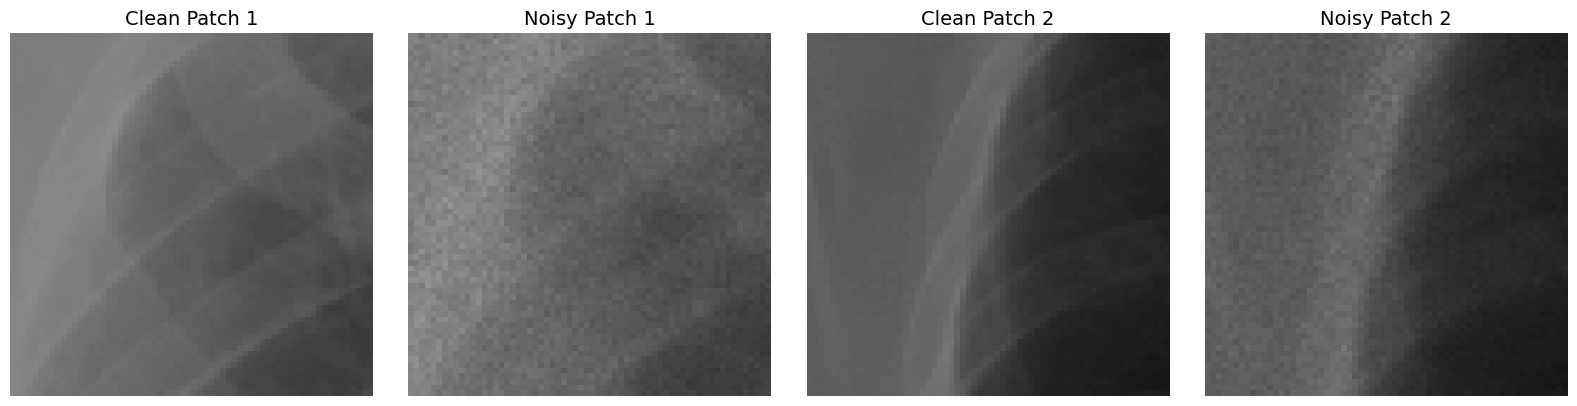

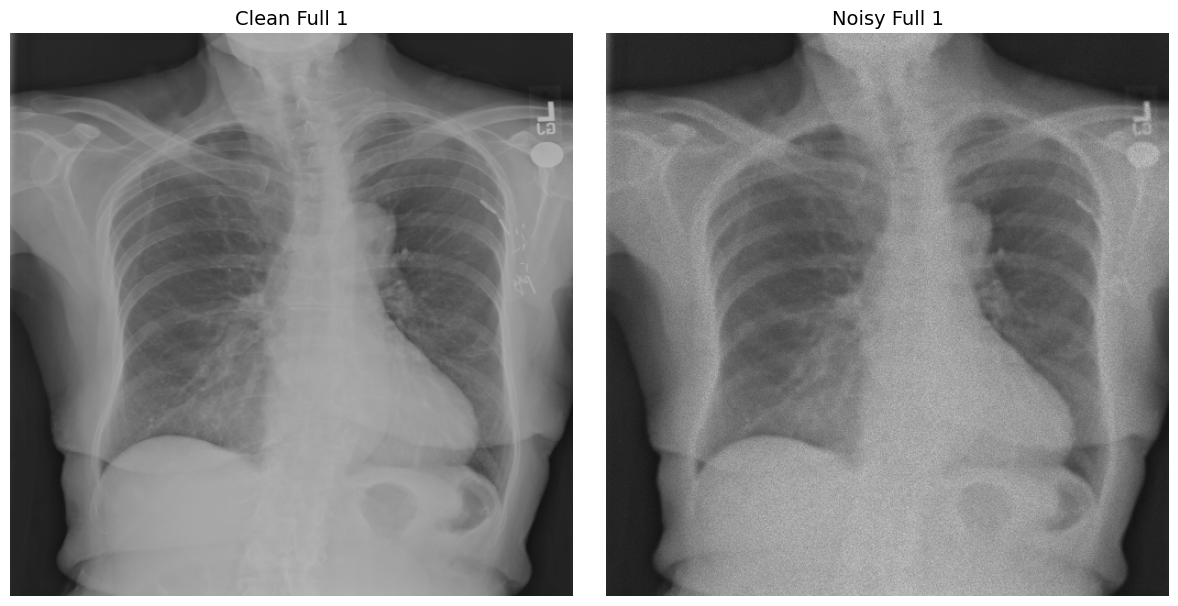

In [47]:
# Noise model
preproc: PreprocessClean = PreprocessClean() # apply to clean images for ground truth
noiser: ApplyNoise = ApplyNoise(blur_sigma=1.0) # apply to preproc to get noisy features

# Examples
import cxr_plt
to_tensor = transforms.ToTensor()

# Example Patches
example_patch_batch = torch.stack(
    [to_tensor(Image.open(f"examples/patch_{i:02d}.png").convert("L")) for i in range(1, 7)]
    ).to(device) 


example_patch_clean = preproc(example_patch_batch)
example_patch_noisy = noiser(example_patch_clean)

cxr_plt.plot_cxr_images(
    [example_patch_clean[0], example_patch_noisy[0], example_patch_clean[1], example_patch_noisy[1]], 
    ["Clean Patch 1", "Noisy Patch 1", "Clean Patch 2", "Noisy Patch 2"], figsize=(4*4, 4))

# Example Full
example_full_batch = torch.stack(
    [to_tensor(Image.open(f"examples/full_{i:02d}.png").convert("L")) for i in range(1, 3)]
    ).to(device) 

example_full_clean = preproc(example_full_batch)
example_full_noisy = noiser(example_full_clean)

cxr_plt.plot_cxr_images(
    [example_full_clean[0], example_full_noisy[0]], 
    ["Clean Full 1", "Noisy Full 1"], figsize=(6*2, 6))



In [48]:
######## NAIVE MODELS ###########
import torch.nn as nn
import torch
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

class MedianFilter(nn.Module):
    def __init__(self, ksize=3):
        super().__init__()
        self.ksize = ksize

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (N,C,H,W), float in [0,1] or any range
        """
        pad = self.ksize // 2
        # pad edges
        x_padded = F.pad(x, (pad, pad, pad, pad), mode='reflect')  # (N,C,H+ks,H+ks)
        
        # extract sliding patches
        patches = x_padded.unfold(2, self.ksize, 1).unfold(3, self.ksize, 1)  # (N,C,H,W,ks,ks)
        patches = patches.contiguous().view(*patches.shape[:4], -1)  # flatten ks*ks dims
        
        # median along the last dimension
        out = patches.median(dim=-1).values  # (N,C,H,W)
        return out



no_denoise = nn.Identity()
median_filter_5 = MedianFilter(ksize=5)
#gaussian_filter_5 = GaussianFilter(ksize=5, sigma=1.0)

median_filter_7 = MedianFilter(ksize=7)
#gaussian_filter_7 = GaussianFilter(ksize=7, sigma=1.0)


naive_models = {
    "No Denoising": no_denoise,
    "Median Filter (5x5)": median_filter_5,
    #"Gaussian Filter (5x5)": gaussian_filter_5,
    "Median Filter (7x7)": median_filter_7,
    #"Gaussian Filter (7x7)": gaussian_filter_7,
}

In [49]:
from train_util import *
import csv
import os

results_csv_path = "naive/test_metrics.csv"

# Check if file exists
file_exists = os.path.isfile(results_csv_path)

with open(results_csv_path, mode="a" if file_exists else "w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header only if new file
    if not file_exists:
        writer.writerow(["Model", "PSNR", "SSIM", "L1"])

    for model_name, model in naive_models.items():
        model.to(device)

        # Metric Evaluations 
        test_metrics = evaluate_metrics_on_dataloader(model, test_dl, preproc, noiser, device)
        
        # Print to console
        print(f"== Metrics on Test data ({model_name}) ==")
        print(f"PSNR: {test_metrics['psnr']:.4f}")
        print(f"SSIM: {test_metrics['ssim']:.4f}")
        print(f"L1:   {test_metrics['l1']:.6f}\n")

        # Write row to CSV
        writer.writerow([
            model_name,
            f"{test_metrics['psnr']:.4f}",
            f"{test_metrics['ssim']:.4f}",
            f"{test_metrics['l1']:.6f}"
        ])

        example_patch_output = model(example_patch_noisy.to(device))
        save_cxr_triplet(example_patch_clean, example_patch_noisy, example_patch_output, f"naive/{model_name}_example_patch.png")

        example_full_output = model(example_full_noisy.to(device))
        save_cxr_triplet(example_full_clean, example_full_noisy, example_full_output,  f"naive/{model_name}_example_full.png")

print(f"Results appended to {results_csv_path}")


== Metrics on Test data (No Denoising) ==
PSNR: 33.0590
SSIM: 0.7566
L1:   0.015602

== Metrics on Test data (Median Filter (5x5)) ==
PSNR: 36.5834
SSIM: 0.9426
L1:   0.007556

== Metrics on Test data (Median Filter (7x7)) ==
PSNR: 35.6783
SSIM: 0.9391
L1:   0.007733

Results appended to naive/test_metrics.csv


In [50]:
import os
import csv
import torch
from diagnosis import NihTester

preproc_and_noiser = torch.nn.Sequential(preproc, noiser)
nih_tester = NihTester(nih_train, device=device)

auc_csv_path = "naive/auc_metrics.csv"
file_exists = os.path.isfile(auc_csv_path)

with open(auc_csv_path, mode="a" if file_exists else "w", newline="") as f:
    writer = csv.writer(f)

    # Write header only if new file
    if not file_exists:
        header = ["Model"] + nih_tester.diagnosis_model.targets[0,:] + ["avg_auc", "total_auc"]
        writer.writerow(header)
        naive_models["Clean"] = nn.Identity()
        naive_models["Clean(no preproc)"] = nn.Identity()

    for model_name, model in naive_models.items():
        model.to(device)
        # Compute AUC metrics
        if model_name == "Clean(no preproc)": 
            model_roc_aucs = nih_tester.rocs(model, nn.Identity())
        elif model_name == "Clean":
            model_roc_aucs = nih_tester.rocs(model, preproc)
        else:
            model_roc_aucs = nih_tester.rocs(model, preproc_and_noiser)

        model_avg_auc = model_roc_aucs.avg_auc_score()
        model_tot_auc = model_roc_aucs.total_auc_score()

        # Collect row: model name + individual AUCs + avg + total
        row = [model_name] + [f"{model_roc_aucs.auc_score(i):.4f}" for i in range(14)]
        row += [f"{model_avg_auc:.4f}", f"{model_tot_auc:.4f}"]

        # Write row
        writer.writerow(row)

        # Print summary
        print(f"== AUC Scores for {model_name} ==")
        for i in range(14):
            print(f"  {model_roc_aucs.targets[i]} AUC: {model_roc_aucs.auc_score(i):.4f}")
        print(f"Model Average AUC: {model_avg_auc:.4f}")
        print(f"Model Total AUC: {model_tot_auc:.4f}\n")

print(f"AUC scores appended to {auc_csv_path}")

TypeError: list indices must be integers or slices, not tuple